In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import shapely

In [2]:
print(shapely.__version__)
print(pd.__version__)

1.8.4
1.1.5


### Reading data

Main data source: https://public.opendatasoft.com/explore/dataset/georef-france-commune/

In [3]:
georef = gpd.read_file('georef-france-commune.geojson')
print(georef.head())

        com_name_upper bv2012_code com_siren_code               arrdep_name  \
0          VILLESISCLE       11049      211104385               Carcassonne   
1                AUBIN       12089      211200134  Villefranche-de-Rouergue   
2  BALAGUIER-SUR-RANCE       12208      211200191                    Millau   
3         LA CAVALERIE       12145      211200639                    Millau   
4  CLAIRVAUX-D'AVEYRON       12138      211200662                     Rodez   

  ept_code com_type com_uu2020_code   reg_name       bv2012_name com_code  \
0     None  commune           11000  Occitanie              Bram    11438   
1     None  commune           12302  Occitanie       Decazeville    12013   
2     None  commune           12000  Occitanie    Saint-Affrique    12019   
3     None  commune           12000  Occitanie            Millau    12063   
4     None  commune           12000  Occitanie  Marcillac-Vallon    12066   

   ... arrdep_code          ze2020_name com_area_code reg_code

In [4]:
georef.to_csv('test_geometry.csv')

In [5]:
georef.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 34968 entries, 0 to 34967
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   com_name_upper        34968 non-null  object  
 1   bv2012_code           34955 non-null  object  
 2   com_siren_code        34955 non-null  object  
 3   arrdep_name           34826 non-null  object  
 4   ept_code              130 non-null    object  
 5   com_type              34968 non-null  object  
 6   com_uu2020_code       34955 non-null  object  
 7   reg_name              34968 non-null  object  
 8   bv2012_name           34955 non-null  object  
 9   com_code              34968 non-null  object  
 10  com_current_code      34968 non-null  object  
 11  com_cateaav2020_code  34955 non-null  object  
 12  ept_name              130 non-null    object  
 13  dep_code              34968 non-null  object  
 14  com_name              34968 non-null  object  

### Parsing inputs and loading additional data sources

In [6]:
georef.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [7]:
# changing coordinate
georef = georef.to_crs('EPSG:2154')
georef.crs

<Projected CRS: EPSG:2154>
Name: RGF93 / Lambert-93
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: France - onshore and offshore, mainland and Corsica.
- bounds: (-9.86, 41.15, 10.38, 51.56)
Coordinate Operation:
- name: Lambert-93
- method: Lambert Conic Conformal (2SP)
Datum: Reseau Geodesique Francais 1993
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

#### Define climatic zone

In [8]:
# loading climatic zone
climatic_zone_detailed = pd.read_csv('zone_climatique.csv', index_col=[0]).to_dict()['Zone Climatique']
detailed_to_agg = {'H1A': 'H1', 'H1B': 'H1', 'H1C': 'H1', 'H2A': 'H2', 'H2B': 'H2', 'H2C': 'H2', 'H2D': 'H2', 'H3': 'H3'}
climatic_zone = {k: detailed_to_agg[item] for k, item in climatic_zone_detailed.items()}

In [9]:
# climatic zone
georef['dep_code'] = georef['dep_code'].astype(str)
georef['climatic_zone'] = georef['dep_code'].replace(climatic_zone)
georef['climatic_zone_detailed'] = georef['dep_code'].replace(climatic_zone_detailed)

georef = georef[georef['climatic_zone'].isin(['H1', 'H2', 'H3'])]

In [10]:
# define climatic zone
zones = dict()
for i in ['H1', 'H2', 'H3']:
    s = georef.loc[georef['climatic_zone'] == i, 'geometry']
    zones.update({i: gpd.GeoSeries(s.unary_union)})

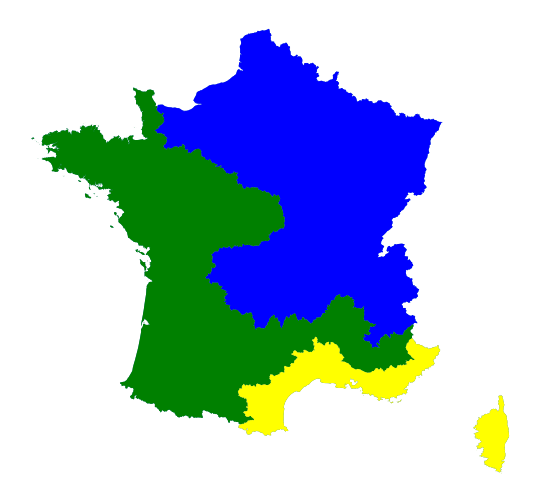

In [11]:
# plot climatic zone
color = {'H1': 'blue', 'H2': 'green', 'H3': 'yellow'}
fig, ax = plt.subplots(figsize=(16, 9))
georef['geometry'].plot(ax=ax)
for k, zone in zones.items():
    zone.plot(ax=ax, color=color[k])
ax.set_axis_off()
plt.show()

In [16]:
zones = {k: zone.iloc[0] for k, zone in zones.items()}

#### Define border H1-H2 and H2-H3

In [17]:
borders = dict()
borders['H1-H2'] = zones['H1'].intersection(zones['H2'])
borders['H2-H3'] = zones['H2'].intersection(zones['H3'])

In [18]:
print(type(borders['H1-H2']))
print(type(borders['H2-H3']))

<class 'shapely.geometry.multilinestring.MultiLineString'>
<class 'shapely.geometry.multilinestring.MultiLineString'>


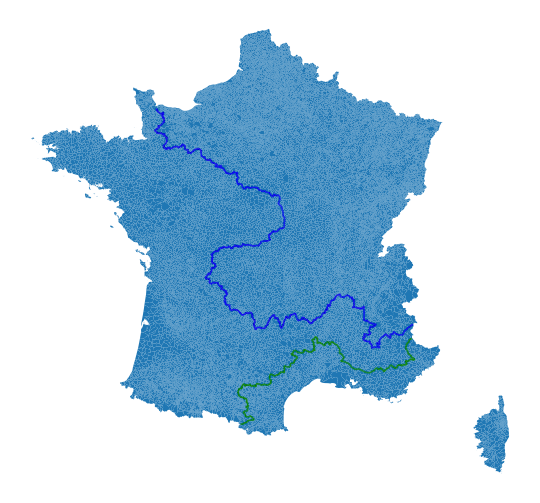

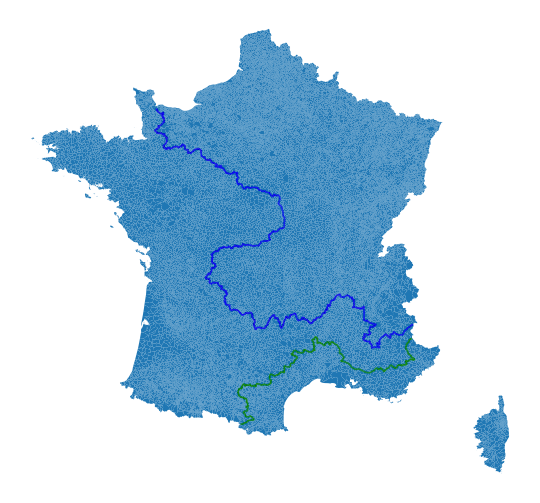

In [20]:
# plot climatic borders
color = {'H1-H2': 'blue', 'H2-H3': 'green'}
fig, ax = plt.subplots(figsize=(16, 9))
georef['geometry'].plot(ax=ax)
for k, border in borders.items():
    gpd.GeoDataFrame(geometry=[border]).plot(ax=ax, color=color[k])
ax.set_axis_off()
plt.show()

### Calculate distance for each commune to the climatic zone border

In [21]:
# simple example with one city

city = georef.loc[2, :]
print(city['climatic_zone'])
print(city['geometry'].distance(borders['H1-H2']))
print(city['geometry'].centroid.distance(borders['H1-H2']))
print(city['geometry'].distance(borders['H2-H3']))
print(city['geometry'].centroid.distance(borders['H2-H3']))

H2
81426.47193152823
83305.42774582416
24545.354977206513
26752.98052673176


In [22]:
# example with multiple cities (10 cities)

georef.loc[:10, :].centroid.distance(borders['H1-H2'])

0     154502.717375
1      10067.065972
2      83305.427746
3      72143.910401
4      25880.141204
5      52990.029598
6      77846.611204
7      18712.012751
8      71535.145651
9      44872.360121
10     68358.560037
dtype: float64

In [23]:
# these following lines take a lot of times

for k, border in borders.items():
    print(k)
    georef['distance {}'.format(k)] = georef.centroid.distance(border)

H1-H2
H2-H3


In [24]:
georef.drop('geometry', axis=1).to_csv('distance_borders.csv')

In [30]:
vars = ['com_name_upper', 'arrdep_name', 'climatic_zone_detailed', 'distance H1-H2', 'distance H2-H3']
georef[vars].head(20)

,com_name_upper,arrdep_name,climatic_zone_detailed,distance H1-H2,distance H2-H3
0,VILLESISCLE,Carcassonne,H3,154502.717375,16459.510123
1,AUBIN,Villefranche-de-Rouergue,H2C,10067.065972,93875.669250
2,BALAGUIER-SUR-RANCE,Millau,H2C,83305.427746,26752.980527
3,LA CAVALERIE,Millau,H2C,72143.910401,10717.909207
4,CLAIRVAUX-D'AVEYRON,Rodez,H2C,25880.141204,76543.299128
5,COMPEYRE,Millau,H2C,52990.029598,15697.195100
6,COUPIAC,Millau,H2C,77846.611204,32166.354924
7,ESCANDOLIÈRES,Villefranche-de-Rouergue,H2C,18712.012751,84064.480835
8,LAPANOUSE-DE-CERNON,Millau,H2C,71535.145651,16462.706883
9,PONT-DE-SALARS,Millau,H2C,44872.360121,48730.972461
